In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SIT723/fer2013.csv')

pixels = data['pixels']
emotions = data['emotion']
usages = data['Usage']

num_of_instances = len(data) #Get the number of data sets
print("The number of data sets is:",num_of_instances)


In [ ]:
#Tidy up the dataset
from tensorflow.keras.utils import to_categorical

#emotions_Str=['anger','disgust','fear','happy','neutral','sad','surprised']
num_classes = 7   #Number of emoticons
x_train,y_train,x_val,y_val,x_test,y_test = [],[],[],[],[],[]
from tqdm import tqdm
for i in tqdm(range(num_of_instances)):
    #one_hot_label = to_categorical(emotions[i],num_classes) #Tags are converted to one-hot encoding to meet the data requirements of keras
    img = list(map(eval,pixels[i].split(' ')))
    np_img = np.asarray(img)
    img = np_img.reshape(48,48)
    if usages[i] == 'Training':
        x_train.append(img)
        y_train.append(emotions[i])
    elif usages[i] == 'PrivateTest':
        x_val.append(img)
        y_val.append(emotions[i])
    else:
        x_test.append(img)
        y_test.append(emotions[i])

# convert data to array format
x_train = np.array(x_train)
y_train = np.array(y_train)
x_train = x_train.reshape(-1,48,48,1)
x_test = np.array(x_test)
y_test = np.array(y_test)
x_test = x_test.reshape(-1,48,48,1)
x_val = np.array(x_val).reshape(-1,48,48,1)
y_val = np.array(y_val)

#Length and shape of data
print('Length of training, testing, validating are:')
len(x_train),len(x_test),len(x_val)

x_val.shape

100%|██████████| 35887/35887 [04:40<00:00, 128.13it/s]


Length of training, testing, validating are:


(3589, 48, 48, 1)

In [ ]:
from keras.engine import input_spec
import numpy as np
import pandas as pd
#Load already prepared FER2013 (faster)
x_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/train_x.csv",header=None)
y_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/train_y.csv",header=None)
x_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/test_x.csv",header=None)
y_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/test_y.csv",header=None)
x_val = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/val_x.csv",header=None)
y_val = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/val_y.csv",header=None)

x_train = np.array(x_train)
x_train = x_train.reshape(28709,48,48,1)
y_train = np.array(y_train)
x_test = np.array(x_test)
x_test = x_test.reshape(3589,48,48,1)
y_test = np.array(y_test)
x_val = np.array(x_val)
x_val = x_val.reshape(3589,48,48,1)
y_val = np.array(y_val)

#For conveniency when training
trainx = x_train
trainy = y_train
testx = x_test
testy = y_test
valx = x_val
valy = y_val


Display 25 images from the train set in the form of 5x5 matrix with their respective labels:


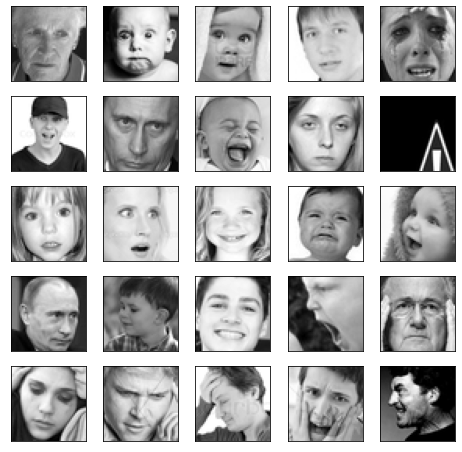

In [ ]:
# Displaying 25 images from training dataset in 5x5 matrix
print("Display 25 images from the train set in the form of 5x5 matrix with their respective labels:")
plt.figure(figsize=[8,8])
for i in range(25):
  plt.subplot(5,5,1+i)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_train[50+i].reshape([48,48]), cmap='gray')
plt.show()

In [ ]:
#CBAM

from __future__ import print_function
import keras
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import resnet_v1, mobilenets
from utils import lr_schedule
import numpy as np
import matplotlib.pyplot as plt
import os

# Training parameters
batch_size = 128
epochs = 80
data_augmentation = False
num_classes = 7
subtract_pixel_mean = True  # Subtracting pixel mean improves accuracy
base_model = 'MobileNet'
# Choose what attention_module to use: cbam_block / se_block / None
attention_module = ['None','cbam_block']


# Load the CIFAR10 data.
#(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Load FER2013 Dataset
x_train = trainx
y_train = trainy
x_test = testx
y_test = testy
x_val = valx
y_val = valy


# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_val = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
y_val = to_categorical(y_val, num_classes)


depth = 20 # For ResNet, specify the depth (e.g. ResNet50: depth=50, ResNet101: Depth=101)
#model = resnet_v1.resnet_v1(input_shape=input_shape, depth=depth,num_classes=7, attention_module='cbam_block')
model = mobilenets.MobileNet(input_shape=input_shape, classes=num_classes, attention_module=attention_module[1])

#model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=lr_schedule(0)),metrics=['accuracy'])
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.01),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    #history = model.fit(x_train, y_train,batch_size=batch_size, epochs=epochs,validation_data=(x_test, y_test), shuffle=True,callbacks=callbacks)
    history = model.fit(x_train, y_train,batch_size=batch_size, epochs=epochs,validation_data=(x_test, y_test), shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    #history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
    history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    validation_data=(x_val, y_val),
                    epochs=epochs, verbose=1, workers=4,
                    callbacks=callbacks)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)


def plot_model_history(history):
  # Plot training loss values
  print("Plot loss values (Train vs. Validation)")
  plt.figure(figsize=(8, 5))
  plt.plot(history.history['loss'],label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()

  print("Plot the accuracy (Train and Validation)")
  plt.figure(figsize=(8, 5))
  plt.plot(history.history['accuracy'],label='Training Accuracy')
  plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()

plot_model_history(history)

x_train shape: (28709, 48, 48, 1)
y_train shape: (28709, 1)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "se_mobilenet_1.00_48"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 24, 24, 32)   288         input_6[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 24, 24, 32)   128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (Activation)         (None, 24, 24, 32)   0           conv1_bn[0][0]                   
_______________________________________________________________________________

In [ ]:
from keras.applications.imagenet_utils import obtain_input_shape
from keras.applications.imagenet_utils import decode_predictions

In [ ]:
#face recognition packages
!pip install opencv-python
!pip install face_recognition

     |████████████████████████████████| 100.1 MB 7.2 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566184 sha256=89103594df4876c279dbeac3fde820bf008624a869306726d980044dbaa217fb
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [ ]:
#face detection using both face_recognition and cv2 packages
import face_recognition
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image

face_cascade_name = cv2.data.haarcascades + 'haarcascade_frontalface_alt.xml'
face_cascade = cv2.CascadeClassifier()
if not face_cascade.load(cv2.samples.findFile(face_cascade_name)):
    print("Error loading xml file")
    exit(0)

count = 0
x_temp = np.array()
y_temp = np.array()

for i in range(1,len(x_test)):
  img = np.array(x_test[i],'uint8')
  face_detect_1 = face_recognition.face_locations(img) #Using face_recoginition
  face_detect_2 = face_cascade.detectMultiScale(img,1.1, 1) #Using cv2
  if (len(face_detect_1)>0):
    (y, w, h, x) = face_detect_1[0]

    count += 1
  else: 
    if (len(face_detect_2)>0):
      (x, y, w, h) = face_detect_2[0]
      count += 1
    else: (y, w, h, x) = 0,0,0,0
  #cv2.rectangle(img, (x, y), (x+w, y+h), (0,0,0), 1)
  #print(i, x, y, w, h)
  #cv2_imshow(cv2.resize(img, (96,96)))
count


RuntimeError: ignored

In [ ]:
x_train.shape

(28709, 48, 48, 1)